1. Desciptive stats inkl sentiment evt. - Ellen
> Avg. sentiment for hver udgiver, wordclouds, correlation heatmap for engagement metrics, plot timeseries (article count og eller engangement sum over tid). Plus andre gode idéer :).
2. sLDA - Julius
> Først normal LDA, vis topics og lav regression som baseline og så sLDA.
3. NN text - Jens
4. CNN billeder - Cille og Benji

# Project: Engagement prediction of news articles on Facebook

**42578 Advanced Business Analytics**

DTU, 1st of April 2022

_Name and study ID_: 

| Name | Study ID |
| --- | --- |
| Benjamin | s184314|
| Cecilie | s184304|
| Ellen | s184313|
| Jens | s183568 | 
| Julius | s184288 | 

## Description of chosen dataset
This dataset *Internet news data with readers engagement* is downloaded from Kaggle (link: https://www.kaggle.com/szymonjanowski/internet-articles-data-with-users-engagement). The dataset contains basic information about news articles: publisher, author, title and a short description together with engagement signals on Facebook (e.g. number of likes). Besides that, each article is provided with an URL to both the news article and associated photo, so it is possible to scrape extra information.   

The dataset consists of 10.437 rows and 14 columns. The data was collected between 03.09.2019 and 03.10.2019 (DD.MM.YYYY). 


## Research questions

This project will focus on how the engagement of new articles is impacted by the contents of the article such as the title, description and the image. To carry out the analysis several research questions have been created:

* Which attributes contribute most to the engagement?

* What metric best describes the value of engagement based on the given counts of shares, comments and reactions?

* What similarities can be found between the articles with a high engagement count?

* How can a supervised LDA model be used to predict engagement based on topics?

* Can the prediction be improved by using neural networks for modeling both the article content and image?


## Descriptive Stats

To begin with some descriptive statistics is carried out in order to understand and process the data for the following analysis. 

**Loading packages**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot
import matplotlib.dates
from datetime import datetime
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns

import gensim
from gensim.models.ldamodel import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models
from gensim import corpora, models
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
from nltk import word_tokenize, sent_tokenize, wordpunct_tokenize, pos_tag
from nltk.tokenize import WordPunctTokenizer, RegexpTokenizer
from nltk.corpus import stopwords, PlaintextCorpusReader, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer
from stopwords import get_stopwords

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import the following in order to access the .csv document in the folder
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
df = pd.read_csv("articles_data.csv", index_col=0)
df.head(5)

source_id         source_name              author  \
0             reuters             Reuters   Reuters Editorial   
1     the-irish-times     The Irish Times  Eoin Burke-Kennedy   
2     the-irish-times     The Irish Times   Deirdre McQuillan   
3  al-jazeera-english  Al Jazeera English          Al Jazeera   
4            bbc-news            BBC News            BBC News   

                                               title  \
0  NTSB says Autopilot engaged in 2018 California...   
1       Unemployment falls to post-crash low of 5.2%   
2  Louise Kennedy AW2019: Long coats, sparkling t...   
3  North Korean footballer Han joins Italian gian...   
4  UK government lawyer says proroguing parliamen...   

                                         description  \
0  The National Transportation Safety Board said ...   
1  Latest monthly figures reflect continued growt...   
2  Autumn-winter collection features designer’s g...   
3  Han is the first North Korean player in the Se...   
4  The UK government's lawyer, David Johnston arg...   

                                                 url  \
0  https://www.reuters.com/article/us-tesla-crash...   
1  https://www.irishtimes.com/business/economy/un...   
2  https://www.irishtimes.com/\t\t\t\t\t\t\t/life...   
3  https://www.aljazeera.com/news/2019/09/north-k...   
4  https://www.bbc.co.uk/news/av/uk-scotland-4956...   

                                        url_to_image          published_at  \
0  https://s4.reutersmedia.net/resources/r/?m=02&...  2019-09-03T16:22:20Z   
1  https://www.irishtimes.com/image-creator/?id=1...  2019-09-03T10:32:28Z   
2  https://www.irishtimes.com/image-creator/?id=1...  2019-09-03T14:40:00Z   
3  https://www.aljazeera.com/mritems/Images/2019/...  2019-09-03T17:25:39Z   
4  https://ichef.bbci.co.uk/news/1024/branded_new...  2019-09-03T14:39:21Z   

                                             content  top_article  \
0  WASHINGTON (Reuters) - The National Transporta...          0.0   
1  The States jobless rate fell to 5.2 per cent l...          0.0   
2  Louise Kennedy is showing off her autumn-winte...          1.0   
3  Han Kwang Song, the first North Korean footbal...          0.0   
4                                                NaN          0.0   

   engagement_reaction_count  engagement_comment_count  \
0                        0.0                       0.0   
1                        6.0                      10.0   
2                        NaN                       NaN   
3                        0.0                       0.0   
4                        0.0                       0.0   

   engagement_share_count  engagement_comment_plugin_count  
0                  2528.0                              0.0  
1                     2.0                              0.0  
2                     NaN                              NaN  
3                     7.0                              0.0  
4                     0.0                              0.0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10437 entries, 0 to 10436
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   source_id                        10437 non-null  object 
 1   source_name                      10437 non-null  object 
 2   author                           9417 non-null   object 
 3   title                            10435 non-null  object 
 4   description                      10413 non-null  object 
 5   url                              10436 non-null  object 
 6   url_to_image                     9781 non-null   object 
 7   published_at                     10436 non-null  object 
 8   content                          9145 non-null   object 
 9   top_article                      10435 non-null  float64
 10  engagement_reaction_count        10319 non-null  float64
 11  engagement_comment_count         10319 non-null  float64
 12  engagement_share_c

In [5]:
#total engagement
df['total_engagement'] = df.engagement_reaction_count + df.engagement_comment_count + df.engagement_share_count + df.engagement_comment_plugin_count

In [6]:
print("The 'content' column has:", df.content.isna().sum(), "missing values")

The 'content' column has: 1292 missing values


In [7]:
print("The 'description' column has:", df.description.isna().sum(), "missing values")

The 'description' column has: 24 missing values


In [8]:
print("The 'title' column has:", df.title.isna().sum(), "missing values")

The 'title' column has: 2 missing values


We can see that the column `content` has 1292 missing values. We need to figure out what to do with these. Maybe we should just use the description column, which only has 24 of missing values

**Creating a new date column with yyyy-mm-dd** 

From the info of the dataset it can be seen that the `publised_at` attribute is defined as an object. This attribute is a date, thus it has to be transformed to date type. 

In [9]:
df['Date']= pd.to_datetime(df['published_at'])#.dt.date #remove the '.dt.date' if you want to keep the time of the day

In [10]:
# We can now look at what the timeframe of the data is
print("The earliest date is:", df["Date"].min())
print("The latest date is:", df["Date"].max())

The earliest date is: 2019-09-03 00:00:00+00:00
The latest date is: 2019-10-03 17:49:31+00:00


In the following we count observations per day:

In [11]:
df["Date"].dt.date.value_counts().tolist()

[843, 841, 817, 814, 807, 804, 772, 770, 759, 754, 639, 630, 596, 590]

In [12]:
df["Date"].dt.date.unique().tolist()

[datetime.date(2019, 9, 3),
 NaT,
 datetime.date(2019, 9, 5),
 datetime.date(2019, 9, 6),
 datetime.date(2019, 9, 7),
 datetime.date(2019, 9, 9),
 datetime.date(2019, 9, 10),
 datetime.date(2019, 9, 12),
 datetime.date(2019, 9, 14),
 datetime.date(2019, 9, 15),
 datetime.date(2019, 9, 19),
 datetime.date(2019, 9, 27),
 datetime.date(2019, 10, 1),
 datetime.date(2019, 10, 2),
 datetime.date(2019, 10, 3)]

There is row with missing date. We take a look at this row: 

In [13]:
df[df.Date.isnull()]

source_id source_name author  title description  url url_to_image  \
750         1       460.0  151.0  352.0         0.0  NaN          NaN   

    published_at content  top_article  engagement_reaction_count  \
750          NaN     NaN          NaN                        NaN   

     engagement_comment_count  engagement_share_count  \
750                       NaN                     NaN   

     engagement_comment_plugin_count  total_engagement Date  
750                              NaN               NaN  NaT

In [14]:
df[df.source_name == "460.0"]

source_id source_name author  title description  url url_to_image  \
750         1       460.0  151.0  352.0         0.0  NaN          NaN   

    published_at content  top_article  engagement_reaction_count  \
750          NaN     NaN          NaN                        NaN   

     engagement_comment_count  engagement_share_count  \
750                       NaN                     NaN   

     engagement_comment_plugin_count  total_engagement Date  
750                              NaN               NaN  NaT

This row has a lot of missing values (NaN) and the `source_name`=460.0. This does not make a lot of sence, so the row is dropped. 

In [15]:
df = df.drop(df[df.source_name == "460.0"].index)

In [16]:
df.Date.dt.date.unique().tolist()

[datetime.date(2019, 9, 3),
 datetime.date(2019, 9, 5),
 datetime.date(2019, 9, 6),
 datetime.date(2019, 9, 7),
 datetime.date(2019, 9, 9),
 datetime.date(2019, 9, 10),
 datetime.date(2019, 9, 12),
 datetime.date(2019, 9, 14),
 datetime.date(2019, 9, 15),
 datetime.date(2019, 9, 19),
 datetime.date(2019, 9, 27),
 datetime.date(2019, 10, 1),
 datetime.date(2019, 10, 2),
 datetime.date(2019, 10, 3)]

In [17]:
fig = make_subplots(rows=1, cols=1)

fig.add_trace(
go.Scatter(x=df.Date.dt.date.unique().tolist(), y=df.Date.dt.date.value_counts()),
row=1, col=1)

fig.update_layout(height=600, width=900, title_text="Observations per day (year 2019)")
fig.show()


We will explore the distribution of weekdays. 

In [18]:
TimeOfDay=[]
for i in df.Date:
    TimeOfDay.append(i.strftime("%H"))

In [19]:
df['Day_Of_Week'] = df.Date.apply(lambda x: x.dayofweek)
df['Month'] = df.Date.apply(lambda x: x.month)
df['Year'] = df.Date.apply(lambda x: x.year)
df['Hour'] = df.Date.apply(lambda x: x.hour)
df['Hour_Of_Week'] = (df['Day_Of_Week'] - 1) * 24 + df['Hour']

In [20]:
day=df.groupby("Day_Of_Week")["source_id"].count().index
num_articles=df.groupby("Day_Of_Week")["source_id"].count()
fig = px.bar(x=day, y=num_articles, height=500, width=900)
fig.update_xaxes(title_text='DayOfWeek')
fig.update_yaxes(title_text='# articles')
fig.update_xaxes(type='category')

fig.show()

In [21]:
time_of_day=df.groupby("Hour")["source_id"].count().index
y=df.groupby("Hour").source_id.count().to_list()

fig = px.bar(x=time_of_day, y=y, height=500, width=900)
fig.update_xaxes(title_text='Time Of Day')
fig.update_yaxes(title_text='# Articles')
fig.update_xaxes(type='category')
fig.show()

We can take a look on the `engagement_reaction_count`, `engagement_comment_count` and `engagement_share_count`.

In [22]:
df.groupby(['Day_Of_Week']).engagement_reaction_count.mean()

Day_Of_Week
0    385.049206
1    598.035250
2    397.056356
3    277.135270
4    324.982569
5    339.302564
6    284.868379
Name: engagement_reaction_count, dtype: float64

In [23]:
val = df.groupby(['Day_Of_Week', 'top_article']).engagement_reaction_count.mean().unstack().reset_index()
val

top_article  Day_Of_Week         0.0          1.0
0                      0  363.772973   542.493333
1                      1  472.926554  1624.023166
2                      2  357.573964   703.839080
3                      3  245.404829   541.524781
4                      4  226.373913  1130.189349
5                      5  370.956947   120.716216
6                      6  275.461538   351.571429

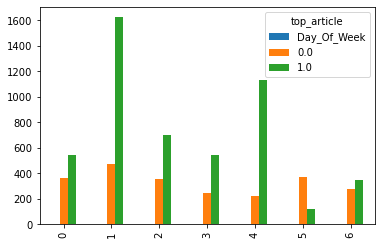

In [24]:
val.plot(kind='bar');

Engagement count is compared for reaction, share and comment for each day of week

In [25]:
#Drop NaN
#df = df.dropna()

In [26]:
# This function is from the following website: https://www.kaggle.com/code/thomaskonstantin/exploring-and-modeling-internet-news-data/notebook

fig = make_subplots(rows=3, cols=1, subplot_titles=('Engagement Reaction Count','Engagement Comment Count','Engagement Share Count'))

b_date_mean = df.copy()
b_date_mean.published_at = pd.to_datetime(b_date_mean.published_at).dt.normalize()
b_date_mean = b_date_mean.groupby(by='published_at').mean().reset_index()

fig.add_trace(
go.Scatter(x=b_date_mean.published_at, y=b_date_mean.engagement_reaction_count,name='engagement_reaction_count'),
row=1, col=1)

fig.add_trace(
go.Scatter(x=b_date_mean.published_at, y=b_date_mean.engagement_comment_count,name='engagement_comment_count'),
row=2, col=1)

fig.add_trace(
go.Scatter(x=b_date_mean.published_at, y=b_date_mean.engagement_share_count,name='engagement_share_count'),
row=3, col=1)

fig.update_layout(height=600, width=900, title_text="Behavior Of Different Engagement Attributes Over Time")
fig.show()

**Looking at the occurences of each data source/news page**

In [27]:
fig = px.bar(x=df["source_name"].unique(), y = df['source_name'].value_counts(), height=500, width=900)
fig.update_xaxes(title_text='Source name')
fig.update_yaxes(title_text='#Observations')
fig.update_xaxes(type='category')
fig.show()

**We are investigating..**

In [28]:
df.content[0]

'WASHINGTON (Reuters) - The National Transportation Safety Board said Tuesday a Tesla Model S was in Autopilot mode when it struck a fire truck in Culver City, California one of a series of crashes the board is investigating involving Tesla’s driver assistance… [+478 chars]'

In the information about the dataset it says the following:   
- *Content column value indicates the unformatted content of the article. This field is truncated to 260 characters.*
 


**How many `top_article`=1 do we have?**

In [29]:
fig = px.pie(values=df.index.value_counts().values, names=df['top_article'])
fig.show()

Only 12.2% of the rows in the data represents a top article. 

Now let us investigate the different types of engament based on the day of the week the articles are published

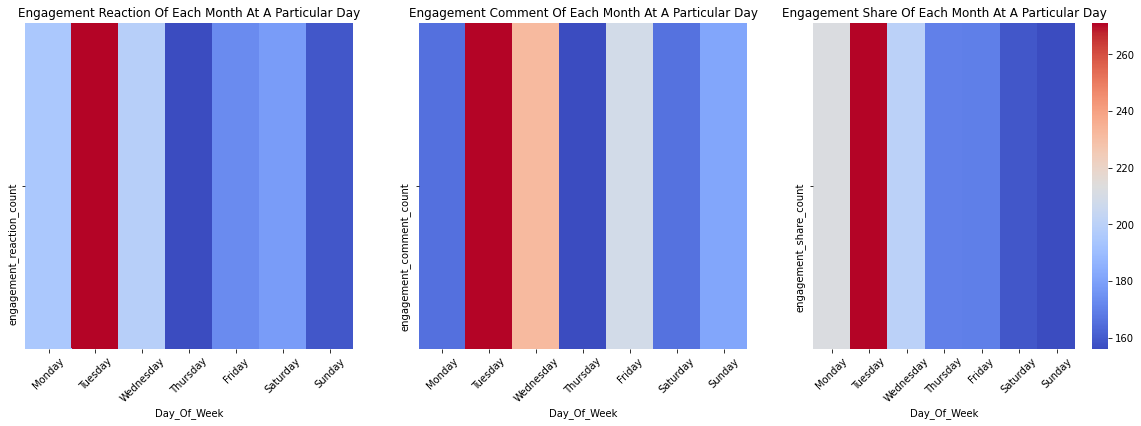

In [30]:
plt.rcParams["figure.figsize"]=[20,6]
plt.subplot(1,3,1)
plt.title('Engagement Reaction Of Each Month At A Particular Day')
ax1 = sns.heatmap(df.pivot_table(columns='Day_Of_Week',values='engagement_reaction_count'),cbar=False,cmap='coolwarm')
ax1.set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], rotation = 45)
#ax1.set(xlabel='Day of Week', ylabel='Engagement reaction count')
plt.subplot(1,3,2)
plt.title('Engagement Comment Of Each Month At A Particular Day')
ax2 = sns.heatmap(df.pivot_table(columns='Day_Of_Week',values='engagement_comment_count'),cbar=False,cmap='coolwarm')
ax2.set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], rotation = 45)
#ax2.set(xlabel='Day of Week', ylabel='Engagement reaction count')
plt.subplot(1,3,3)
plt.title('Engagement Share Of Each Month At A Particular Day')
ax3 = sns.heatmap(df.pivot_table(columns='Day_Of_Week',values='engagement_share_count'),cmap='coolwarm')
ax3.set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], rotation = 45)
#ax3.set(xlabel='Day of Week', ylabel='Engagement reaction count')
plt.show()

### Should we chose only one engagement metric?

In [119]:
fig = make_subplots(rows=1, cols=1,shared_xaxes=True)

s_val =df[["top_article", "Day_Of_Week", "Month", "engagement_reaction_count", "engagement_comment_count", "engagement_share_count"]].corr('pearson')
s_idx = s_val.index
s_col = s_val.columns
s_val = s_val.values
fig.add_trace(
    go.Heatmap(x=s_col,y=s_idx,z=s_val,name='pearson',xgap=1,ygap=1, colorscale='RdBu'),
    row=1, col=1)

fig.update_layout(height=600, width=900, title_text="Correlation between the engagement metrics")
fig.show()

There is a high correlation between all three engagement metrics, thus we can choose to select one of them. Another solution could be to combine the metrics into one. 

### Word clouds for article titles and descriptions.

In [31]:
from wordcloud import WordCloud,STOPWORDS
import re
import matplotlib.pyplot as plt

In [32]:
df.title = df.title.str.lower()
df = df[~df.title.isna()]
df.title = df.title.apply(lambda x: ' '.join(re.findall(r'\w+', x)) )
df.title = df.title.apply(lambda x:x.strip())

df.description = df.description.str.lower()
df = df[~df.description.isna()]
df.description = df.description.apply(lambda x: ' '.join(re.findall(r'\w+', x)) )
df.description = df.description.apply(lambda x:x.strip())

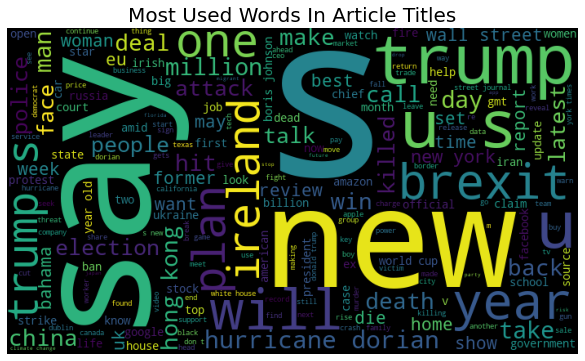

In [33]:
wc = WordCloud(width=700,height=400,stopwords=STOPWORDS).generate(' '.join(df.title))
plt.imshow(wc)
plt.axis('off')
plt.title("Most Used Words In Article Titles",fontsize=20)
plt.show()

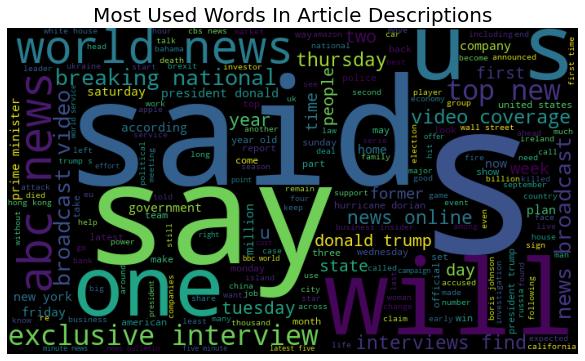

In [34]:
wc = WordCloud(width=700,height=400,stopwords=STOPWORDS).generate(' '.join(df.description))
plt.imshow(wc)
plt.axis('off')
plt.title("Most Used Words In Article Descriptions",fontsize=20)
plt.show()

In [35]:
#remove char and do stemming
wc = WordCloud(width=700,height=400,stopwords=STOPWORDS).generate(' '.join(df.content))
plt.imshow(wc)
plt.axis('off')
plt.title("Most Used Words In Article content",fontsize=20)
plt.show()

TypeError: sequence item 4: expected str instance, float found

## Sentiment

In [41]:
df.head()

source_id         source_name              author  \
0             reuters             Reuters   Reuters Editorial   
1     the-irish-times     The Irish Times  Eoin Burke-Kennedy   
2     the-irish-times     The Irish Times   Deirdre McQuillan   
3  al-jazeera-english  Al Jazeera English          Al Jazeera   
4            bbc-news            BBC News            BBC News   

                                               title  \
0  ntsb says autopilot engaged in 2018 california...   
1        unemployment falls to post crash low of 5 2   
2  louise kennedy aw2019 long coats sparkling twe...   
3  north korean footballer han joins italian gian...   
4  uk government lawyer says proroguing parliamen...   

                                         description  \
0  the national transportation safety board said ...   
1  latest monthly figures reflect continued growt...   
2  autumn winter collection features designer s g...   
3  han is the first north korean player in the se...   
4  the uk government s lawyer david johnston argu...   

                                                 url  \
0  https://www.reuters.com/article/us-tesla-crash...   
1  https://www.irishtimes.com/business/economy/un...   
2  https://www.irishtimes.com/\t\t\t\t\t\t\t/life...   
3  https://www.aljazeera.com/news/2019/09/north-k...   
4  https://www.bbc.co.uk/news/av/uk-scotland-4956...   

                                        url_to_image          published_at  \
0  https://s4.reutersmedia.net/resources/r/?m=02&...  2019-09-03T16:22:20Z   
1  https://www.irishtimes.com/image-creator/?id=1...  2019-09-03T10:32:28Z   
2  https://www.irishtimes.com/image-creator/?id=1...  2019-09-03T14:40:00Z   
3  https://www.aljazeera.com/mritems/Images/2019/...  2019-09-03T17:25:39Z   
4  https://ichef.bbci.co.uk/news/1024/branded_new...  2019-09-03T14:39:21Z   

                                             content  top_article  ...  \
0  WASHINGTON (Reuters) - The National Transporta...          0.0  ...   
1  The States jobless rate fell to 5.2 per cent l...          0.0  ...   
2  Louise Kennedy is showing off her autumn-winte...          1.0  ...   
3  Han Kwang Song, the first North Korean footbal...          0.0  ...   
4                                                NaN          0.0  ...   

   engagement_comment_count  engagement_share_count  \
0                       0.0                  2528.0   
1                      10.0                     2.0   
2                       NaN                     NaN   
3                       0.0                     7.0   
4                       0.0                     0.0   

   engagement_comment_plugin_count  total_engagement  \
0                              0.0            2528.0   
1                              0.0              18.0   
2                              NaN               NaN   
3                              0.0               7.0   
4                              0.0               0.0   

                       Date Day_Of_Week  Month  Year  Hour  Hour_Of_Week  
0 2019-09-03 16:22:20+00:00           1      9  2019    16            16  
1 2019-09-03 10:32:28+00:00           1      9  2019    10            10  
2 2019-09-03 14:40:00+00:00           1      9  2019    14            14  
3 2019-09-03 17:25:39+00:00           1      9  2019    17            17  
4 2019-09-03 14:39:21+00:00           1      9  2019    14            14  

[5 rows x 21 columns]

In [42]:
df['Negative']=''
df['Neutral']=''
df['Positive']=''
df['Compound']=''

In [43]:
analyzer = SentimentIntensityAnalyzer()

for i, text in df.iterrows():
    df['Negative'][i]=analyzer.polarity_scores(text['description'])['neg']
    df['Neutral'][i]=analyzer.polarity_scores(text['description'])['neu']
    df['Positive'][i]=analyzer.polarity_scores(text['description'])['pos']
    df['Compound'][i]=analyzer.polarity_scores(text['description'])['compound']

df[['Compound','Negative','Neutral','Positive']] = df[['Compound','Negative','Neutral','Positive']].astype('float64')

In [44]:
df['Sentiment']=''
for i, score in df.iterrows(): #
    if score['Compound'] >=0.5:   #positive threshold
        df['Sentiment'][i] = 'Positive'
    elif score['Compound']<=-0.5: #negative threshold
        df['Sentiment'][i] = 'Negative' 
    else:
        df['Sentiment'][i] = 'Neutral'

In [45]:
positive_art=df[df['Sentiment']=='Positive']
neutral_art=df[df['Sentiment']=='Neutral']
negative_art=df[df['Sentiment']=='Negative']

print("Total number of articles:", len(df))
count_neg=len(negative_art)
count_neu=len(neutral_art)
count_pos=len(positive_art)
print("Number of negative articles:", count_neg)
print("Number of neutral articles:", count_neu)
print("Number of positive articles:", count_pos)

Total number of articles: 10410
Number of negative articles: 2091
Number of neutral articles: 6620
Number of positive articles: 1699


In [46]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "histogram"}]]) #Making two plots

colors=['forestgreen','gold','indianred'] #Setting the color
labels = 'Positive', 'Neutral', 'Negative' #Setting the labels
values = [count_pos, count_neu, count_neg] #Stating the values for the pie plot

#Plotting the pie plot
fig.add_trace(go.Pie(labels=labels, values=values,name="",showlegend=False,marker=dict(colors=colors,line=dict(color='#ffffff', width=6))),
     row=1, col=1)


#Plotting the histogram(negative)
fig.add_trace(go.Histogram(x=df.loc[df['Sentiment']=='Negative']['Compound'],name="Negative",marker=dict(color="indianred"),xbins=dict(
        start=-1.0,
        end=1,
        size=0.1
    )),
    row=1, col=2)
#Plotting the histogram(positive)
fig.add_trace(go.Histogram(x=df.loc[df['Sentiment']=='Positive']['Compound'],name="Positive",marker=dict(color="forestgreen"),xbins=dict(
        start=-1.0,
        end=1,
        size=0.1
    )),
    row=1, col=2)
#Plotting the histogram(neutral)
fig.add_trace(go.Histogram(x=df.loc[df['Sentiment']=='Neutral']['Compound'],name="Neutral",marker=dict(color="gold"),xbins=dict(
        start=-1.0,
        end=1,
        size=0.1
    )),
    row=1, col=2)


fig.update_layout(
    title_text='Sentiment distribution ',title_x=0.5 # title of plot

)

config = {'displayModeBar': False}

fig.show(config=config)

In [47]:
grouped_count=df.groupby(['source_name','Sentiment']).count().reset_index()
grouped_count=grouped_count[['source_name','Sentiment','source_id']] 
grouped_count['source_id'] = grouped_count['source_id'] / grouped_count.groupby('source_name')['source_id'].transform('sum')*100
grouped_count

source_name Sentiment  source_id
0                  ABC News  Negative  21.334504
1                  ABC News   Neutral  69.183494
2                  ABC News  Positive   9.482002
3        Al Jazeera English  Negative  27.272727
4        Al Jazeera English   Neutral  63.838384
5        Al Jazeera English  Positive   8.888889
6                  BBC News  Negative  18.760064
7                  BBC News   Neutral  67.713366
8                  BBC News  Positive  13.526570
9          Business Insider  Negative  14.599237
10         Business Insider   Neutral  53.244275
11         Business Insider  Positive  32.156489
12                 CBS News  Negative  27.415966
13                 CBS News   Neutral  59.243697
14                 CBS News  Positive  13.340336
15                      CNN  Negative  21.364452
16                      CNN   Neutral  60.053860
17                      CNN  Positive  18.581688
18                     ESPN  Negative  15.853659
19                     ESPN   Neutral  68.292683
20                     ESPN  Positive  15.853659
21                 Newsweek  Negative  20.593692
22                 Newsweek   Neutral  65.120594
23                 Newsweek  Positive  14.285714
24                  Reuters  Negative  24.440895
25                  Reuters   Neutral  58.386581
26                  Reuters  Positive  17.172524
27          The Irish Times  Negative  14.634146
28          The Irish Times   Neutral  69.674797
29          The Irish Times  Positive  15.691057
30       The New York Times  Negative  15.345528
31       The New York Times   Neutral  67.886179
32       The New York Times  Positive  16.768293
33  The Wall Street Journal  Negative  20.120120
34  The Wall Street Journal   Neutral  66.366366
35  The Wall Street Journal  Positive  13.513514

In [48]:
long_df = grouped_count

#Plotting
fig = px.bar(long_df, x="source_name", y="source_id", color="Sentiment", title="Sentiment distribution per publisher",
             labels={'source_id':'%','source_name':'Publisher','Sentiment':''}, color_discrete_map={
        'Positive': 'forestgreen',
        'Neutral': 'gold','Negative': 'indianred'})
for data in fig.data:
    data["width"] = 0.6 #Change this value for bar widths

fig.update_layout(title_x=0.5, legend=dict(
        x=1.0,
        y=0.5,        
    ))

config = {'displayModeBar': False}
fig.show(config=config)

In [49]:
for idx in df['Compound'].nlargest(5).index:
    print("Article desription:")
    print(df.loc[idx].description)
    print("Total engagement: ",df.loc[idx].total_engagement)

Article desription:
carving out time to sit down and read a whole book is great but what if you want to digest something in less time that won t replace the joy of a great novel or nonfiction work but it can entertain and occupy your time while commuting on the train
Total engagement:  8.0
Article desription:
i m a huge disney fan with a particular love for all things mickey mouse naturally it was a total dream to scour the internet in search of the cutest coolest and most fun gifts you could give a disney fan besides tickets to their favorite park whether
Total engagement:  6.0
Article desription:
tcl is an excellent budget tv brand and its 43s425 and 75s425 tvs are great buys tcl s 4 series tvs are known for their accurate colors great viewing experience and affordable price both sets use the smart roku tv platform and support 4k content for a l
Total engagement:  2.0
Article desription:
beauty subscription boxes are nothing new but as an affordable way to try new skincare and makeup

In [50]:
for idx in df['Compound'].nsmallest(5).index:
    print("Article desription:")
    print(df.loc[idx].description)
    print("Total engagement: ",df.loc[idx].total_engagement)

Article desription:
amber guyger former dallas officer found guilty of murder in death of neighbor the new york times ex cop who killed neighbor in his own home found guilty of murder live updates cnn jury resumes deliberations in amber guyger murder trial msnnow jury deliber
Total engagement:  67813.0
Article desription:
the mother of a woman killed when a man rammed his car through a crowd of anti racism protesters in virginia is suing the convicted murderer for wrongful death
Total engagement:  0.0
Article desription:
taliban bombing flattens hospital kills at least 15 in afghanistan the wall street journal u s drone strike kills 30 pine nut farm workers in afghanistan reuters afghanistan war deadly taliban attack destroys hospital bbc news taliban violence in afghani
Total engagement:  351.0
Article desription:
activists in south africa are protesting a wave of violence against women after several women were recent raped and brutally murdered south african president cyril ramaphosa

## LDA

In [51]:
#This code is used in the topic modeling part when cleaning the data
contractions = {"ain't": "am not",
                "'cause": "because",
                "could've": "could have",
                "didnt": "did not",
                "hadnt": "had not",
                "haven't": "have not",
                "havent": "have not",
                "how'd": "how did",
                "how'll": "how will",
                "it'd": "it would",
                "it'll": "it will",
                "mayn't": "may not",
                "might've": "might have",
                "mightn't": "might not",
                "must've": "must have",
                "mustn't": "must not",
                "needn't": "need not",
                "oughtn't": "ought not",
                "shan't": "shall not",
                "should've": "should have",
                "shouldnt": "should not",
                "that'd": "that would",
                "there'd": "there would",
                "theres": "there is",
                "wasn't": "was not",
                "wasnt": "was not",
                " u ": " you ",
                " ur ": " your ",
                " n ": " and "} 

In [52]:
#This code will be used to calculate corpus and vocabulary size in the topic modeling part
vocab_size = [] #Saving the vocabolary size reduction

from functools import reduce
def lyrics_to_lists(df, columns):
    #https://stackoverflow.com/questions/39291499/how-to-concatenate-multiple-column-values-into-a-single-column-in-panda-datafram
    slist = [df[x].astype(str) for x in columns]
    client_comments=reduce(lambda x, y: x + ' ' + y, slist[1:], slist[0])
    return client_comments


def lyrics_to_doc(df, columns):
    client_comments = lyrics_to_lists(df,columns)
    return client_comments.str.cat(sep=' ')


def top_n_words(split_doc,n):
    # Pass the split_it list to instance of Counter class.
    from collections import Counter
    Counter = Counter(split_doc) 

    # most_common() produces k frequently encountered  
    most_occur = Counter.most_common(n)
    return most_occur

In [53]:
# Function to lemmatize with POS Tag
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    
    if tag.startswith('J'):
        return tag_dict.get(tag,wordnet.ADJ)
    elif tag.startswith('V'):
        return tag_dict.get(tag,wordnet.VERB)
    elif tag.startswith('N'):
        return tag_dict.get(tag,wordnet.NOUN)
    elif tag.startswith('R'):
        return tag_dict.get(tag,wordnet.ADV)
    else:
        # As default pos in lemmatization is Noun
        return tag_dict.get(tag,wordnet.NOUN)

lemmatizer = WordNetLemmatizer()
stemmer    = PorterStemmer()
stop_words =get_stopwords('en')
#stop_words.extend(['use','say','know','get','done','many','some','think','see','rather','lot','want',
#                   'seem','need','even','right','also','take','come','can','dont','cant','please','let','i'])


# Function to add common words to stop words
new_stopwords = []
def rem_stopwords(text):
    #stop_words.extend(new_stopwords)
    text= " ".join([word for word in text.split() if word not in stop_words])
    return text
    

#pattern = '(\[.*?\])'
def remove_noise(text):
    #(1) Strip and lowercase sentence
    text = text.strip()
    text= "".join([word.lower() for word in text])
    
    #(2) Contraction conversion
    for key in contractions:
            value = contractions[key]
            text = text.replace(key, value)
    
    #(3) Remove stopwords
    text = rem_stopwords(text)
    
    #(4) Remove punctuation
    text=text.replace('.','')
    text=text.replace(',','')
    text=text.replace('-','  ')
    cleanr = re.compile('<.*?>')
    text = re.sub(cleanr, '', text)
    text = re.sub('[0-9]+', '', text)
      
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)

    
    #(5) Lemmatize songs with POS tags
    text= " ".join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]) #nltk.word_tokenize(text)
    
    
    #(6) Adding one extra whitespace at the end of each song. 
    #    This should handle issues with necessary corrections of words in the end of strings 
    string_length=len(text)+2
    text=text.center(string_length)
    
    return text

#Function used in topic modeling for cleaning the data (remove rare and short words)
def remove_rare_short(text):
    #use list named 'rare'
    text= " ".join([word for word in text.split() if word not in rare])
    text= " ".join([word for word in text.split() if len(word) >= 2])
    return text

In [54]:
vocab=len(set(lyrics_to_doc(df,['description']).split()))
vocab_size.append(('Raw text',vocab))
print('Corpus vocabulary size: ', vocab)
print('Corpus size: ', len(lyrics_to_doc(df,['description']).split()))

Corpus vocabulary size:  21300
Corpus size:  277349


In [55]:
n=10
doc = lyrics_to_doc(df,['description']).split() 
top_n_words(doc,n)

[('the', 13822),
 ('a', 7591),
 ('to', 7044),
 ('of', 6259),
 ('and', 5714),
 ('in', 5464),
 ('s', 4378),
 ('on', 3517),
 ('for', 2592),
 ('is', 2213)]

### Text preprocessing

In [56]:
df['clean_text']=df['description'].apply(remove_noise)

In [57]:
vocab=len(set(lyrics_to_doc(df,['clean_text']).split()))
vocab_size.append(('Noise removal',vocab))
print('Corpus vocabulary size: ', vocab)

Corpus vocabulary size:  16412


In [58]:
#Removing rare and short words
doc = lyrics_to_doc(df,['clean_text']).split()
freq_count = pd.Series(doc).value_counts()
rare = freq_count[freq_count.values == 1]
df['clean_text']=df['clean_text'].apply(remove_rare_short) #Calling a function from the function sectio

In [59]:
#Calculating the new vocabulary size
vocab=len(set(lyrics_to_doc(df,['clean_text']).split())) #Calling a function from the function section
vocab_size.append(('Rare & short words',vocab))
print('Corpus vocabulary size: ', vocab)

Corpus vocabulary size:  9415


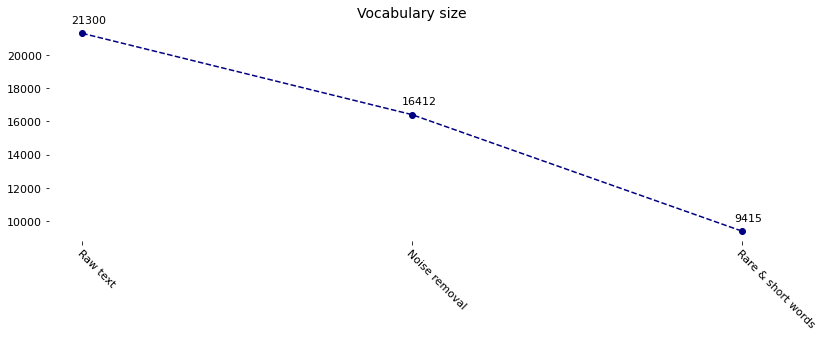

In [60]:
process,count = zip(*vocab_size)
#Plotting the vocabulary reduction 
plt.figure(figsize=(13,4))
plt.clf()
plt.plot(process,count,'o--',color='navy')

# zip joins x and y coordinates in pairs
for x,y in vocab_size:

    label = "{:.0f}".format(y)

    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(7,10), # distance from text to points (x,y)
                 ha='center',
                fontsize=11)

plt.title('Vocabulary size',fontsize=14,color='black')
plt.xticks(fontsize=11,rotation=-45, ha="left",rotation_mode="anchor",color='black')
plt.yticks(fontsize=11)
plt.box(False)
plt.show()

In [61]:
#Looking at top 10 most common words
n=10
doc = lyrics_to_doc(df,['clean_text']).split() #Calling a function from the function section
top_n_words(doc,n) #Calling a function from the function section

[('say', 1989),
 ('news', 1617),
 ('new', 1124),
 ('year', 984),
 ('world', 933),
 ('president', 904),
 ('will', 795),
 ('trump', 752),
 ('get', 739),
 ('national', 663)]

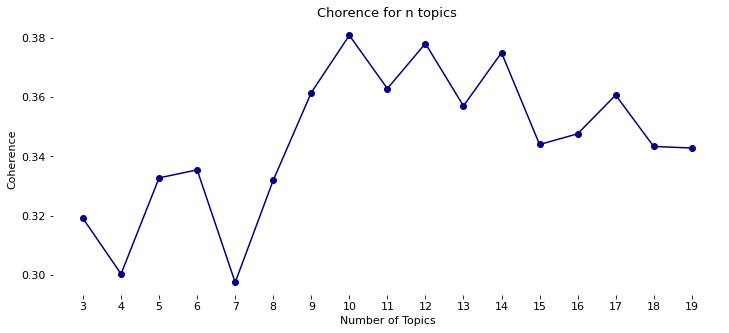

In [62]:
#Prepping model inputs
corpus = df['clean_text'].values.tolist()
tok_corp= [word_tokenize(sent) for sent in corpus]
lexi = corpora.Dictionary(tok_corp)
corpus = [lexi.doc2bow(d) for d in tok_corp]

plt.figure(figsize=(12, 5))

#Choose n parameter based on coherence measure
coherence_vals = []
for k in range(3,20):
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(corpus, num_topics=k,id2word = lexi, eval_every=None,passes=3,
               iterations=10,chunksize=100,random_state=0)

    cm = gensim.models.coherencemodel.CoherenceModel(\
         model=ldamodel, texts=tok_corp, dictionary=lexi, coherence='c_v')   

    coherence_vals.append((k,cm.get_coherence()))

n_topics = [x[0] for x in coherence_vals]
coherence = [x[1] for x in coherence_vals]

plt.plot(n_topics,coherence,color='navy')
plt.scatter(n_topics,coherence,color='navy')
plt.xlabel('Number of Topics',fontsize=11,color='black')
plt.ylabel('Coherence', fontsize=11,color='black')
plt.xticks(n_topics,fontsize=11,color='black')
plt.yticks(fontsize=11,color='black')
plt.title('Chorence for n topics',fontsize=13,color='black')
plt.box(False)

#plt.show()

In [63]:
#Running the LDA model with the optimal number of topics found above
n_sub_topics= 3+coherence.index(max(coherence))
lda = LdaModel(corpus=corpus, id2word=lexi, iterations=10,chunksize=100, passes=3,num_topics=n_sub_topics, 
          update_every=1, alpha='auto', random_state=0,eval_every=None)

In [64]:
#Finding the topics 
topic_data =  pyLDAvis.gensim_models.prepare(lda, corpus, lexi, mds = 'pcoa')
all_topics = {}
num_terms = 10 # Adjust number of words to represent each topic
lambd = 0.8# Adjust this accordingly based on tuning above
for i in range(1,n_sub_topics+1): #Adjust this to reflect number of topics chosen for final LDA model
    topic = topic_data.topic_info[topic_data.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values
    topic_df = pd.DataFrame(all_topics).T
#Display keywords that represents each topic
topic_df

0          1         2         3          4             5  \
Topic 1      say  president     trump    report  wednesday      thursday   
Topic 2      new       year      time     three     murder         woman   
Topic 3     will     police      deal       old      house      minister   
Topic 4     case       want      take    people       work  investigates   
Topic 5      can       make     first      come       http           one   
Topic 6    state     canada     chief     world  executive          home   
Topic 7   disney     market  investor      show        way           see   
Topic 8     hour      staff       big    expect       dead          href   
Topic 9    stock   business     trade     china    insider        public   
Topic 10    news        get       top  national      video          find   

                     6        7        8          9  
Topic 1           call   target   former         go  
Topic 2           last     just      two    million  
Topic 3            com      say    prime      month  
Topic 4         school    found     wife    teacher  
Topic 5            www      son     like     killer  
Topic 6            men  federal    peter     united  
Topic 7          magic  company   medium  statement  
Topic 8        cbsnews   credit  october       help  
Topic 9   intelligence     data      ask    england  
Topic 10        online    break    world  interview

In [65]:
#assigning each song to topics
topic_names=['US President','Murders','Police & Politics','Cases', 'Links','Canada','Big companies',
             'something','Stocks','Top news']
for t in topic_names:
    df[t] = np.zeros(len(df)).astype('int64')
pd.options.mode.chained_assignment = None
for i in range(len(corpus)):
    doc_topics=lda.get_document_topics(corpus[i])
    for topic, prob in doc_topics:
        if prob>=0.4:
            df[topic_names[topic]][i]=1
        else:
            df[topic_names[topic]][i]=0

In [66]:
#Finding average sentiment score for each topic and the number of songs within each topic
sentiment_score=[]
num_customers=[]
for t in topic_names:
    sentiment_score.append(round(df[df[t]==1]['Compound'].mean(),2))
    num_customers.append(len(df[df[t]==1]))
pd.DataFrame({'Topic':topic_names,'Sentiment score': sentiment_score,'Count': num_customers}).set_index('Topic')

Sentiment score  Count
Topic                                    
US President                 -0.17     14
Murders                      -0.10     82
Police & Politics             0.06     41
Cases                        -0.02    406
Links                        -0.07     13
Canada                        0.01      9
Big companies                 0.04     10
something                    -0.01     58
Stocks                        0.03    156
Top news                     -0.02     43

In [67]:
pyLDAvis.display(topic_data)

## Supervised LDA fra stackoverflow - VIRKER IKKE

In [50]:
#!pip3 install pymc3
#!conda install -c conda-forge pymc3 -y

In [54]:
pm

<module 'pymc3' from '/Users/juliusrasmussen/opt/anaconda3/lib/python3.8/site-packages/pymc3/__init__.py'>

In [57]:
import pymc3 as pm
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

train_corpus = ["exploitative and largely devoid of the depth or sophistication ",
                "simplistic silly and tedious",
                "it's so laddish and juvenile only teenage boys could possibly find it funny",
                "it shows that some studios firmly believe that people have lost the ability to think",
                "our culture is headed down the toilet with the ferocity of a frozen burrito",
                "offers that rare combination of entertainment and education",
                "the film provides some great insight",
                "this is a film well worth seeing",
                "a masterpiece four years in the making",
                "offers a breath of the fresh air of true sophistication"]
test_corpus =  ["this is a really positive review, great film"]
train_response = np.array([3, 1, 3, 2, 1, 5, 4, 4, 5, 5]) - 3

#LDA parameters
num_features = 1000  #vocabulary size
num_topics = 4       #fixed for LDA

tfidf = TfidfVectorizer(max_features = num_features, max_df=0.95, min_df=0, stop_words = 'english')

#generate tf-idf term-document matrix
A_tfidf_sp = tfidf.fit_transform(train_corpus)  #size D x V

print("number of docs: %d" %A_tfidf_sp.shape[0])
print("dictionary size: %d" %A_tfidf_sp.shape[1])

#tf-idf dictionary    
tfidf_dict = tfidf.get_feature_names_out()

K = num_topics # number of topics
V = A_tfidf_sp.shape[1] # number of words
D = A_tfidf_sp.shape[0] # number of documents

data = A_tfidf_sp.toarray()

#Supervised LDA Graphical Model
Wd = [len(doc) for doc in data]        
alpha = np.ones(K)
beta = np.ones(V)

theta = pm.Data([pm.Dirichlet("theta_%s" % i, pm.Dirichlet("ptheta_%s" % i, theta=alpha)) for i in range(D)])
phi = pm.Container([pm.CompletedDirichlet("phi_%s" % k, pm.Dirichlet("pphi_%s" % k, theta=beta)) for k in range(K)])    

z = pm.Container([pm.Categorical('z_%s' % d, p = theta[d], size=Wd[d], value=np.random.randint(K, size=Wd[d])) for d in range(D)])

@pm.deterministic
def zbar(z=z):    
    zbar_list = []
    for i in range(len(z)):
        hist, bin_edges = np.histogram(z[i], bins=K)
        zbar_list.append(hist / float(np.sum(hist)))                
    return pm.Container(zbar_list)

eta = pm.Container([pm.Normal("eta_%s" % k, mu=0, tau=1.0/10**2) for k in range(K)])
y_tau = pm.Gamma("tau", alpha=0.1, beta=0.1)

@pm.deterministic
def y_mu(eta=eta, zbar=zbar):
    y_mu_list = []
    for i in range(len(zbar)):
        y_mu_list.append(np.dot(eta, zbar[i]))
    return pm.Container(y_mu_list)

#response likelihood
y = pm.Container([pm.Normal("y_%s" % d, mu=y_mu[d], tau=y_tau, value=train_response[d], observed=True) for d in range(D)])

# cannot use p=phi[z[d][i]] here since phi is an ordinary list while z[d][i] is stochastic
w = pm.Container([pm.Categorical("w_%i_%i" % (d,i), p = pm.Lambda('phi_z_%i_%i' % (d,i), lambda z=z[d][i], phi=phi: phi[z]),
                  value=data[d][i], observed=True) for d in range(D) for i in range(Wd[d])])

model = pm.Model([theta, phi, z, eta, y, w])
mcmc = pm.MCMC(model)
mcmc.sample(iter=1000, burn=100, thin=2)

#visualize topics    
phi0_samples = np.squeeze(mcmc.trace('phi_0')[:])
phi1_samples = np.squeeze(mcmc.trace('phi_1')[:])
phi2_samples = np.squeeze(mcmc.trace('phi_2')[:])
phi3_samples = np.squeeze(mcmc.trace('phi_3')[:])
ax = plt.subplot(221)
plt.bar(np.arange(V), phi0_samples[-1,:])
ax = plt.subplot(222)
plt.bar(np.arange(V), phi1_samples[-1,:])
ax = plt.subplot(223)
plt.bar(np.arange(V), phi2_samples[-1,:])
ax = plt.subplot(224)
plt.bar(np.arange(V), phi3_samples[-1,:])
plt.show()

number of docs: 10
dictionary size: 46


TypeError: No model on context stack, which is needed to instantiate distributions. Add variable inside a 'with model:' block, or use the '.dist' syntax for a standalone distribution.

# Image processing and analysis - Cille

Explanation on the HSV colors can be found in this [link](https://realpython.com/python-opencv-color-spaces/).     
* H = Hue (color)
* S = Saturation (the shades of hue) 
* V = Value (brightness of the color)


<div>
    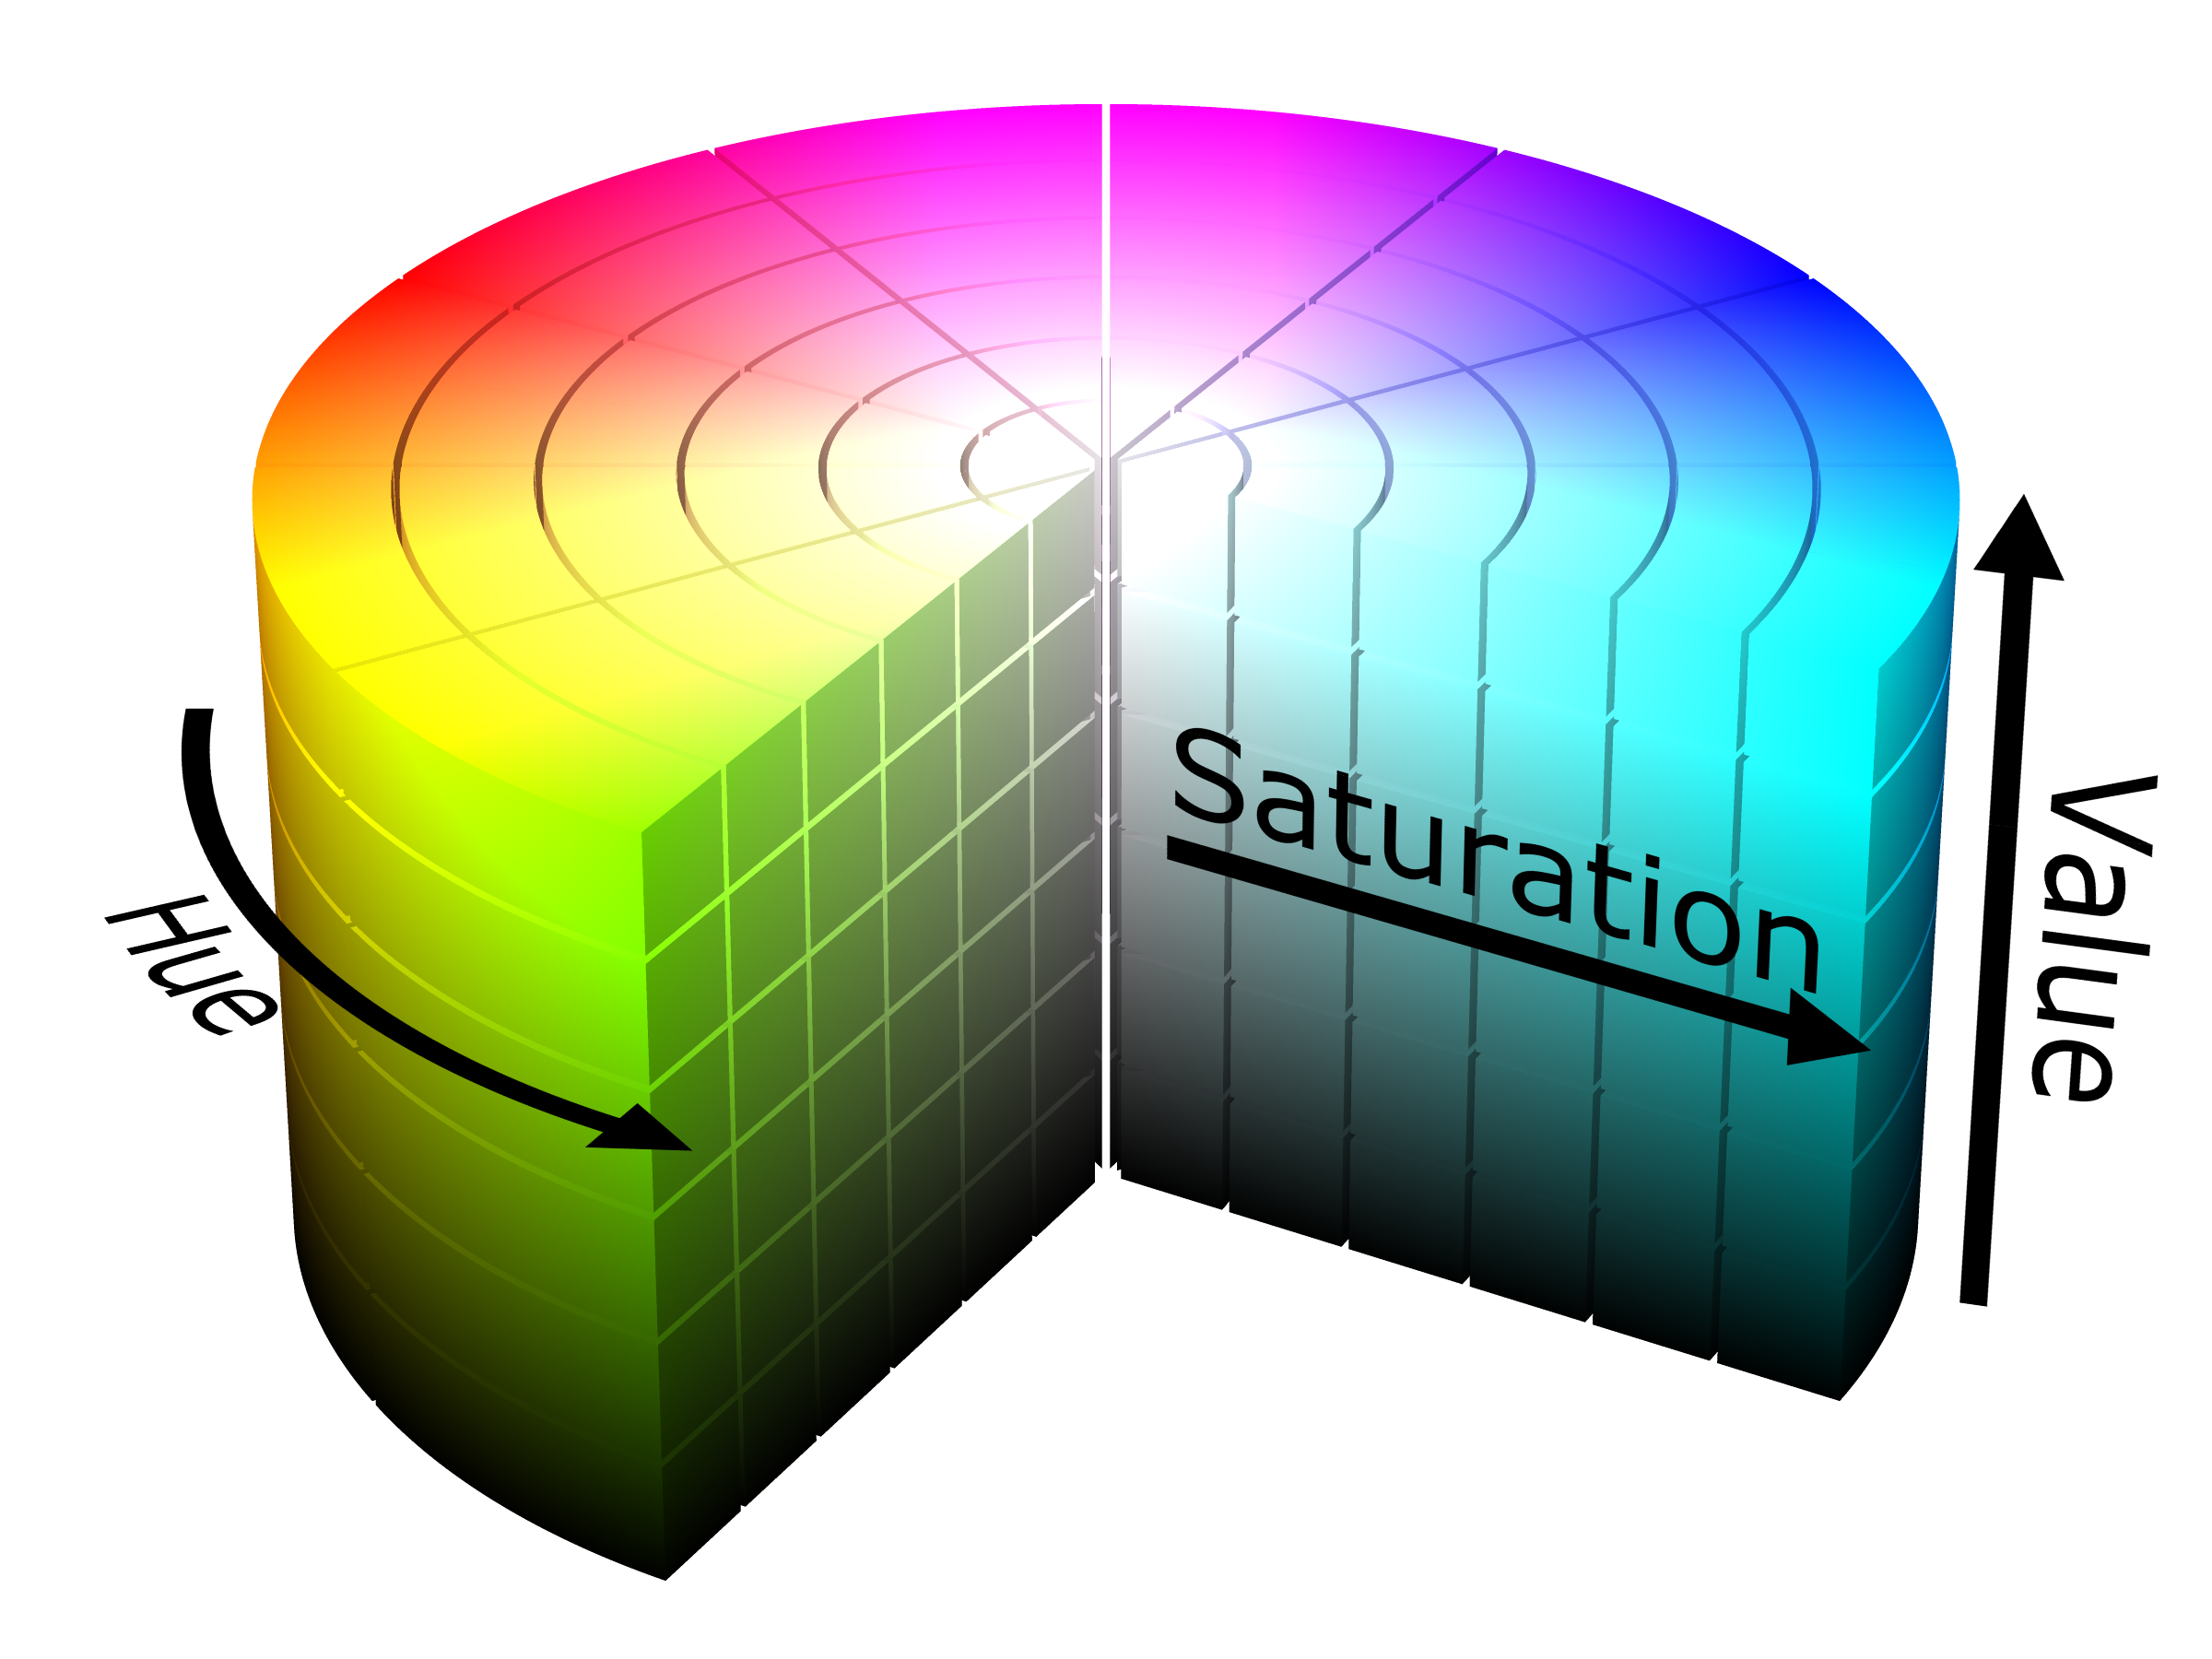
</div>

In [133]:
#pip install opencv-python

In [133]:
import cv2
import requests
import imageio
from PIL import Image
#from scipy import misc

#function to process one image
def process_image(url):
    res = requests.get(url)
    im = imageio.imread((res.content))
    
    #print('Type of the image : ' , type(im)) 
    #print('Shape of the image : {}'.format(im.shape)) 
    #print('Image Height {}'.format(im.shape[0])) 
    #print('Image Width {}'.format(im.shape[1])) 
    #print('Dimension of Image {}'.format(im.ndim))
    
    #get dims
    width = im.shape[1]
    height = im.shape[0]
    dimensions = im.ndim
    
    #getting the HSV colors
    mean_hsv = cv2.mean(cv2.cvtColor(im, cv2.COLOR_BGR2HSV))
    #h,s,v = cv2.split(mean_hsv)
    
    hue_mean = mean_hsv[0]
    sat_mean = mean_hsv[1]
    bright_mean = mean_hsv[2]
    
    #return mean values
    return width,height,dimensions, hue_mean,sat_mean,bright_mean

In [137]:
#function that outputs the image
def print_image(url):
    res = requests.get(url)
    im = imageio.imread((res.content))
    return Image.fromarray(im).resize((500, 300), Image.ANTIALIAS)

In [70]:
url = df.url_to_image[0]
process_image(url)

(1200, 816, 3, 48.257852328431376, 36.47578431372549, 160.3603257761438)

In [216]:
df[["img_width", "img_height", 'img_dim', 'img_hue', 'img_sat', 'img_val']] = np.nan

In [218]:
df = df.reset_index()

In [219]:
#WARNING: This code has a very long runtime (approx 45 min). The output data has been saved in a new csv. So download this instead.

for i in range(len(df)):
    url = df.iloc[i]["url_to_image"]
    if pd.isna(url) == False:
        #print(url)
        try:
            width,height,dimensions,hue_mean,sat_mean,bright_mean = process_image(url)
            df["img_width"][i],  df["img_height"][i], df["img_dim"][i], df["img_hue"][i], df["img_sat"][i], df["img_val"][i] = width,height,dimensions,hue_mean,sat_mean,bright_mean
        except:
            pass

In [221]:
df.to_csv('new_data.csv')

In [222]:
df = pd.read_csv("new_data.csv", index_col=0)

In [209]:
df = df.reset_index()

In [223]:
print("Row with highest Hue:", df['img_hue'].idxmax())
print("Row with highest Saturation:", df['img_sat'].idxmax())
print("Row with highest Brightness:", df['img_val'].idxmax())
print("--------------------------------------------")
print("Row with lowest Hue:", df['img_hue'].idxmin())
print("Row with lowest Saturation:", df['img_sat'].idxmin())
print("Row with lowest Brightness:", df['img_val'].idxmin())

Row with highest Hue: 1261
Row with highest Saturation: 1982
Row with highest Brightness: 641
--------------------------------------------
Row with lowest Hue: 16
Row with lowest Saturation: 16
Row with lowest Brightness: 4275


Image with higest brightness


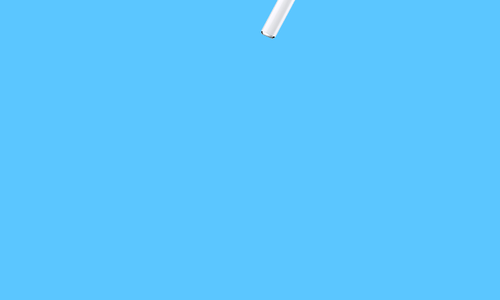

In [224]:
print("Image with higest brightness")
print_image(df.iloc[641].url_to_image)

Image with lowest brightness


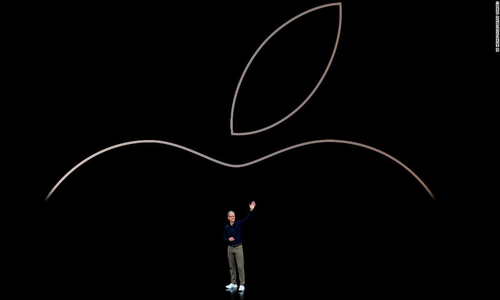

In [225]:
print("Image with lowest brightness")
print_image(df.iloc[4275].url_to_image)

Image with higest saturation


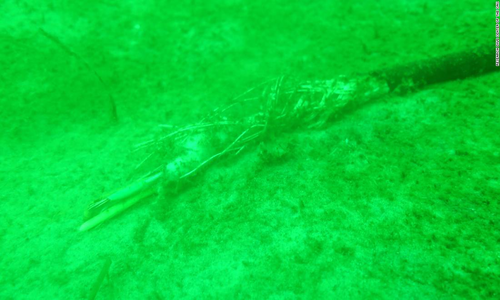

In [226]:
print("Image with higest saturation")
print_image(df.iloc[1982].url_to_image)

Image with lowest saturation


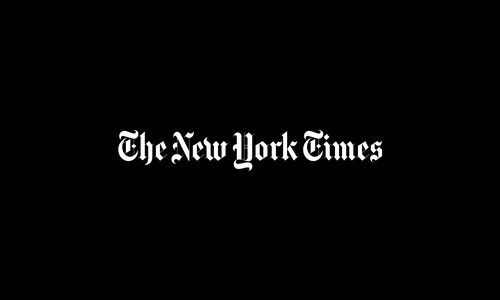

In [227]:
print("Image with lowest saturation")
print_image(df.iloc[16].url_to_image)

## Investigating correlations

In [228]:
df = pd.read_csv("new_data.csv", index_col=0)

In [229]:
fig = make_subplots(rows=1, cols=1,shared_xaxes=True)

s_val =df[["engagement_reaction_count", "engagement_comment_count", "engagement_share_count", "img_hue", "img_sat", "img_val"]].corr('pearson')
s_idx = s_val.index
s_col = s_val.columns
s_val = s_val.values
fig.add_trace(
    go.Heatmap(x=s_col,y=s_idx,z=s_val,name='pearson',xgap=1,ygap=1, colorscale='RdBu'),
    row=1, col=1)

fig.update_layout(height=600, width=900, title_text="Pearson correlation")
fig.show()

Conclusion: We cannot use the HSV to anything.

# CNN - Cille

In [191]:
df = pd.read_csv("new_data.csv", index_col=0)

In [192]:
#df = df.reset_index()

In [230]:
print("Row with highest engagement (reaction count):", df['engagement_reaction_count'].idxmax())
print("Row with lowest engagement (reaction count):", df['engagement_reaction_count'].idxmin())

Row with highest engagement (reaction count): 8474
Row with lowest engagement (reaction count): 0


In [231]:
df[df.engagement_reaction_count == 354132]

level_0  index source_id source_name                          author  \
8474     8474   8500       cnn         CNN  Elizabeth Wolfe And Brian Ries   

                                                  title  \
8474  jimmy carter the oldest living former u s pres...   

                                            description  \
8474  jimmy carter the oldest living former u s pres...   

                                                    url  \
8474  https://www.cnn.com/2019/10/01/us/jimmy-carter...   

                                           url_to_image          published_at  \
8474  https://cdn.cnn.com/cnnnext/dam/assets/1909241...  2019-10-01T10:40:23Z   

      ... Big companies  something  Stocks  Top news  img_width  img_height  \
8474  ...             0          0       0         0     1100.0       619.0   

      img_dim    img_hue    img_sat     img_val  
8474      3.0  98.616255  72.217001  137.274315  

[1 rows x 45 columns]

Image with highest engagement (reaction count)


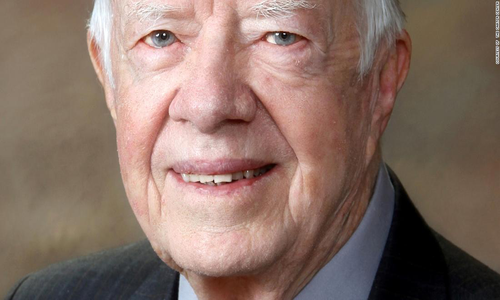

In [232]:
print("Image with highest engagement (reaction count)")
print_image(df.url_to_image[8474])

Image with lowest engagement (reaction count)


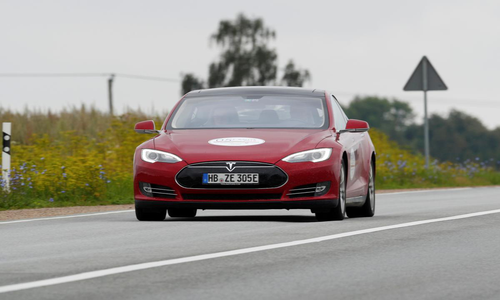

In [233]:
print("Image with lowest engagement (reaction count)")
print_image(df.url_to_image[0])